In [10]:
# Copyright 2018 IBM All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recognize and Count Objects in a Video

An object detection classifier can be used to identify and locate objects in a static image. When using video, you can use the same approach to static detection individual frames.  In this Jupyter Notebook, we'll use the [IBM PowerAI Vision](https://www.ibm.com/us-en/marketplace/ibm-powerai-vision) for object detection and [OpenCV Python API](https://opencv.org/) to process the video.

Before running this notebook, you will need to train and deploy an object detection model. PowerAI Vision has auto-labeling to enhance your dataset for accuracy when using video input. After you train and deploy your model, set the `POWER_AI_VISION_API_URL` constant below to use your model for inference.

Extracting frames and locating objects is easy with OpenCV and PowerAI Vision. The challenge is how to keep track of objects if you want to count them. As an object moves, you will need to be able to determine whether or not you have already counted the object. In this notebook, we'll use the OpenCV Tracking API to follow cars down the road while we run PowerAI Vision object detection on a sample of the frames. With tracking, we'll be able to avoid double counting without requiring a lot of code.


| First Detected... | Followed Down the Road |
| :---: | :---: |
| ![detected](https://raw.githubusercontent.com/IBM/powerai-counting-cars/master/doc/source/images/output-frame_00011.jpg) | ![tracked](https://raw.githubusercontent.com/IBM/powerai-counting-cars/master/doc/source/images/output-frame_00128.jpg) |


## First setup some parameters

### Required setup!

Your PowerAI Vision API URL for the model that you trained and deployed will need to be set here.

In [11]:
# Set this URL using your PowerAI Vision host + /AIVision/api + your deployed web API URL.
POWER_AI_VISION_API_URL = "https://ny1.ptopenlab.com/AIVision/api/dlapis/your-guid-here"


### Optional configuration

Here you can customize some settings to tune your results.

> NOTE: The notebook uses sampling and cached results to speed things up for iterative development. If you change the video, you will need to run with `CLEAN = True` to delete and regenerate your cached frames and inference results!

In [12]:
CLEAN = False  # USE WITH CARE! Wipe out saved files when this is true (else reuse for speed)
input_video_url = "https://ibm.box.com/shared/static/4r4tf2robabiqu36ocmykrzvojuse5k9.mp4" # The input video
FRAMES_DIR = "frames"  # Output dir to hold/cache the original frames
OUTPUT_DIR = "output"  # Output dir to hold the annotated frames
SAMPLING = 10  # Classify every n frames (use tracking in between)
CONFIDENCE = 0.80  # Confidence threshold to filter iffy objects

## Install Python Requirements

In [13]:
!pip install opencv-python==3.4.0.12
!pip install opencv-contrib-python==3.4.0.12
!pip install requests==2.18.4
!pip install pandas==0.22.0
!pip install urllib3==1.22

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
# TODO: Make this compatible with Python 2.
# from __future__ import print_function

import json
import glob
import math
import os
import shutil

import cv2
from IPython.display import clear_output, Image, display
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
print("Warning: Certificates not verified!")

%matplotlib notebook


## Download the video
This will download a small example video.


In [15]:
!wget {input_video_url}
input_video = input_video_url.split('/')[-1]

--2018-04-27 22:51:20--  https://ibm.box.com/shared/static/4r4tf2robabiqu36ocmykrzvojuse5k9.mp4
Resolving ibm.box.com... 107.152.25.197, 107.152.24.197
Connecting to ibm.box.com|107.152.25.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/4r4tf2robabiqu36ocmykrzvojuse5k9.mp4 [following]
--2018-04-27 22:51:20--  https://ibm.ent.box.com/shared/static/4r4tf2robabiqu36ocmykrzvojuse5k9.mp4
Resolving ibm.ent.box.com... 107.152.25.211, 107.152.24.211
Connecting to ibm.ent.box.com|107.152.25.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/c_eDsULrKOYfMEr6WLlGg2R_aQSJ-kFQyBtaBMuHgyfoFr-X5tnfrqYei1NIIbGIBBKMhT7daDeUGTTKa__XtELvnIEDj3q1LGu-cj3xs87gIZuwLiQ3XG2XszYVmHj8T5oWhXUVqzUiD7-oQqRMgpczYgc83BtIp9q629x7sY1PuUDBvlz0g8fjH-sioelG6ogniyxtizddzID6VN5OFH5LSh4Jh_lax4oQQWPwg9slq7lKBtQPba25SihRlOF-14-iYNbp7UTwYoWRSNhywKePWoMJd73LVDBSE6GHH0pyh7pMPTuoViWsj

## Create or clean the directories
Caching the frames and output directories allows the processing to continue where it left off. This is particularly useful when using a shared system with deployment time limits. This also allows you to quickly `Run all` when tweaking Python code that does not affect the inference.

If you change the input video or just want a fresh start, you should `CLEAN` or change the directory names.

In [16]:
if CLEAN:
    if os.path.isdir(FRAMES_DIR):
        shutil.rmtree(FRAMES_DIR)
    if os.path.isdir(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)

if not os.path.isdir(FRAMES_DIR):
    os.mkdir(FRAMES_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

## Parse and explode the video file into JPEGs
Each frame is saved as an individual JPEG file for later use.

In [17]:
if os.path.isfile(input_video):
    video_capture = cv2.VideoCapture(input_video)
else:
    raise Exception("File %s doesn't exist!" % input_video)

total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
print("Frame count estimate is %d" % total_frames)

num = 0
while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
    success, image = video_capture.read()
    if success:
        num = int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))
        print("Writing frame {num} of {total_frames}".format(
            num=num, total_frames=total_frames), end="\r")
        cv2.imwrite('{frames_dir}/frame_{num:05d}.jpg'.format(
            frames_dir=FRAMES_DIR, num=num), image)
    else:
        # TODO: If this happens, we need to add retry code
        raise Exception('Error writing frame_{num:05d}.jpg'.format(
            num=int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))))

print("\nWrote {num} frames".format(num=num))

FRAME_WIDTH = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
FRAME_HEIGHT = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("Frame Dimensions: %sx%s" % (FRAME_WIDTH, FRAME_HEIGHT))

Frame count estimate is 1769
Writing frame 1769 of 1769
Wrote 1769 frames
Frame Dimensions: 960x540


## PowerAI Vision inference wrapper
Define a helper/wrapper to call PowerAI Vision and return the inference result.

In [18]:
s = requests.Session()


def detect_objects(filename):

    # TODO: use with to open/close the file
    f = open(filename, 'rb')
    # WARNING! verify=False is here to allow an untrusted cert!
    r = s.post(POWER_AI_VISION_API_URL,
               files={'files': (filename, f)},
               verify=False)
    f.close()
    return r.status_code, json.loads(r.text)


## Test the API on a single frame
Let's look at the result of a single inference operation from the PowerAI Vision Object Detection API. We see a standard HTTP return code, and a JSON response which includes the image URL, and tuples that indicate the confidence and bounding-box coordinates of the objects that we classified.

In [19]:
rc, jsonresp = detect_objects('frames/frame_00100.jpg')

print("rc = %d" % rc)
print("jsonresp: %s" % jsonresp)
if 'classified' in jsonresp:
    print("Got back %d objects" % len(jsonresp['classified']))
print(json.dumps(jsonresp, indent=2))


rc = 200
jsonresp: {'imageUrl': 'http://ny1.ptopenlab.com:443/AIVision/uploads/temp/dfe0782d-1531-408b-bac9-c81d4e7b1791/6f66c2b7-aa84-423f-a41a-ca25b0be8bbe.jpg', 'imageMd5': '281c4c3836f8fd761efc867be7fc7d10', 'classified': [{'confidence': 0.999650239944458, 'ymax': 343, 'label': 'car', 'xmax': 745, 'xmin': 619, 'ymin': 236}, {'confidence': 0.9996472597122192, 'ymax': 368, 'label': 'car', 'xmax': 503, 'xmin': 373, 'ymin': 249}, {'confidence': 0.999326229095459, 'ymax': 281, 'label': 'car', 'xmax': 414, 'xmin': 298, 'ymin': 188}, {'confidence': 0.9991839528083801, 'ymax': 185, 'label': 'car', 'xmax': 257, 'xmin': 176, 'ymin': 130}, {'confidence': 0.9990304708480835, 'ymax': 247, 'label': 'car', 'xmax': 596, 'xmin': 487, 'ymin': 161}, {'confidence': 0.9877257943153381, 'ymax': 196, 'label': 'car', 'xmax': 420, 'xmin': 352, 'ymin': 122}, {'confidence': 0.9862733483314514, 'ymax': 185, 'label': 'car', 'xmax': 317, 'xmin': 252, 'ymin': 130}], 'result': 'success'}
Got back 7 objects
{
  "i

## Get object detection results for sampled frames
Since we've stored all video frames on disk (for easy reference), we can iterate over those files
and make queries as appropriate to PowerAI Vision's API. We'll store the results in a
`tracking_results` dictionary, organized by file name. Since we are tracking objects from frame
to frame, we can use sampling to decide how often to check for new objects.

We're also caching the results so that you can change later code and run the notebook over
without running the same inference over again.

In [20]:
# Serialize requests, storing them in a "tracking_results" dict

try:
    with open('frames/frame-data-newmodel.json') as existing_results:
        tracking_results = json.load(existing_results)
except Exception:
    # Any fail to read existing results means we start over
    tracking_results = {}

print("Sampling every %sth frame" % SAMPLING)
i = 0
cache_used = 0
sampled = 0
for filename in sorted(glob.glob('frames/frame_*.jpg')):
    i += 1

    if not i % SAMPLING == 0:  # Sample every 100
        continue

    existing_result = tracking_results.get(filename)
    if existing_result and existing_result['result'] == 'success':
        cache_used += 1
    else:
        rc, results = detect_objects(filename)
        if rc != 200 or results['result'] != 'success':
            print("ERROR rc=%d for %s" % (rc, filename))
            print("ERROR result=%s" % results)
        else:
            sampled += 1
            # Save frequently to cache partial results
            tracking_results[filename] = results
            with open('frames/frame-data-newmodel.json', 'w') as fp:
                json.dump(tracking_results, fp)

    print("Processed file {num} of {total_frames} (used cache {cache_used} times)".format(
        num=i, total_frames=total_frames, cache_used=cache_used), end="\r")

# Finally, write all our results
with open('frames/frame-data-newmodel.json', 'w') as fp:
    json.dump(tracking_results, fp)

print("\nDone")


Sampling every 10th frame
Processed file 1760 of 1769 (used cache 0 times)
Done


## Define helper functions for tracking and drawing labels
Refer to the [OpenCV docs.](https://docs.opencv.org/3.4.1/)

In [21]:
ROI_YMAX = int(round(FRAME_HEIGHT * 0.75))  # Bottom quarter = finish line
DROP_YMAX = int(round(FRAME_HEIGHT * 0.95))  # Near bottom = drop it
FILLED = -1


def update_trackers(image):
    boxes = []
    color2 = (240, 218, 85)
    yellow = (66, 244, 238)
    color = (80, 220, 60)
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1
    thickness = 1

    for n, pair in enumerate(trackers):
        tracker, car = pair
        label = str(car)  # TODO: str() once when adding
        textsize, _baseline = cv2.getTextSize(
            str(label), fontface, fontscale, thickness)
        _success, bbox = tracker.update(image)
        boxes.append(bbox)  # Return updated box list

        xmin = int(bbox[0])
        ymin = int(bbox[1])
        xmax = int(bbox[0] + bbox[2])
        ymax = int(bbox[1] + bbox[3])
        xmid = int(round((xmin+xmax)/2))
        ymid = int(round((ymin+ymax)/2))

        if ymax > DROP_YMAX:
            # Drop the tracker when near the very bottom
            del trackers[n]
        elif ymax > ROI_YMAX:
            # Highlight the tracker at the finish line
            # TODO: Work-in-progress:
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color2, FILLED)
        else:
            # Rectangle and number on the cars we are tracking
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 4)
            pos = (xmid - textsize[0]//2, ymid + textsize[1]//2)
            cv2.putText(image, label, pos, fontface, 1, yellow, 4, cv2.LINE_AA)

    return boxes


In [22]:
def not_tracked(objects, boxes):
    if not objects:
        return []  # No new classified objects to search for
    if not boxes:
        return objects  # No existing boxes, return all objects

    new_objects = []
    for obj in objects:
        xmin = obj.get("xmin", "")
        xmax = obj.get("xmax", "")
        ymin = obj.get("ymin", "")
        ymax = obj.get("ymax", "")
        xmid = int(round((xmin+xmax)/2))
        ymid = int(round((ymin+ymax)/2))
        box_range = ((xmax - xmin) + (ymax - ymin)) / 2
        for bbox in boxes:
            bxmin = int(bbox[0])
            bymin = int(bbox[1])
            bxmax = int(bbox[0] + bbox[2])
            bymax = int(bbox[1] + bbox[3])
            bxmid = int((bxmin + bxmax) / 2)
            bymid = int((bymin + bymax) / 2)
            if math.sqrt((xmid - bxmid)**2 + (ymid - bymid)**2) < box_range:
                # found existing, so break (do not add to new_objects)
                break
        else:
            new_objects.append(obj)

    return new_objects


In [23]:
# Draw a small circle in the middle-middle of each detected object in the image
def draw_label(obj, image, cars):
    label = "car %s" % cars
    color = (80, 220, 60)
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1
    thickness = 1
    textsize, _baseline = cv2.getTextSize(
        label, fontface, fontscale, thickness)
    xmin = obj.get("xmin", "")
    xmax = obj.get("xmax", "")
    ymin = obj.get("ymin", "")
    ymax = obj.get("ymax", "")
    xmid = int(round((xmin+xmax)/2))
    ymid = int(round((ymin+ymax)/2))

    # init tracker
    tracker = cv2.TrackerKCF_create()
    success = tracker.init(image, (xmin, ymin, xmax-xmin, ymax-ymin))
    if success:
        trackers.append((tracker, cars))

    # TODO: Refactor and use the update_trackers style highlighting.
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 4)
    cv2.putText(
        image,
        label,
        (xmid - textsize[0]//2, ymin + textsize[1]),
        fontface, 1,
        (255, 255, 255),
        2,
        cv2.LINE_AA)
    cv2.circle(
        image, (xmid, ymid), 5, color, thickness=FILLED, lineType=8, shift=0)


In [24]:
# Draw the current count of objects in the image in the upper-left corner
def draw_count(count, name, image):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,
                name + ": " + str(count),
                (30, 60),
                font,
                1,
                (255, 255, 255),
                2,
                cv2.LINE_AA)


# Draw the running total of objects in the image in the upper-left corner
def draw_sum(count, name, image):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,
                name + " total: " + str(count),
                (30, 150),
                font,
                1,
                (255, 255, 255),
                2,
                cv2.LINE_AA)


## Inference, tracking, and annotation
Loop through the saved frames and:
1. Update the trackers to follow already detected objects from frame to frame.
1. Look for new objects if we ran inference on this frame.
    * Check for overlap with tracked objects.
    * If no overlap, assign a sequence number and start tracking.
1. Write an annotated image with tracked objects highlighted and numbered.

In [25]:
cars = 0
trackers = []

with open('frames/frame-data-newmodel.json') as existing_results:
    tracking_results = json.load(existing_results)

i = 0
for filename in sorted(glob.glob('frames/frame_*.jpg')):
    i += 1
    img = cv2.imread(filename)
    boxes = update_trackers(img)

    if filename in tracking_results and 'classified' in tracking_results[filename]:
        jsonresp = tracking_results[filename]
        for obj in not_tracked(jsonresp['classified'], boxes):
            cars += 1
            draw_label(obj, img, cars)  # Label and start tracking

    cv2.imwrite("output/output-" + filename.split('/')[1], img)
    print("Processed file {num} of {total_frames}".format(
        num=i, total_frames=total_frames), end="\r")

print("\nDone")

Processed file 1769 of 1769
Done


## Play the annotated frames in the notebook

This code will play the annotated frames in a loop to demonstrate the new video.
Running this in the notebook is usually slow. Shrinking the size helps some.
Refer to the following section to build a real, full speed video.

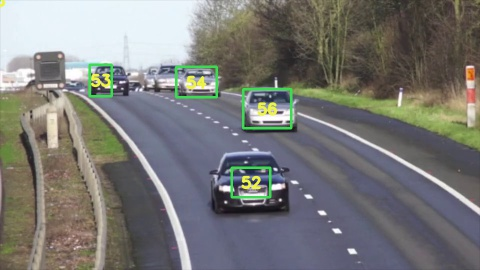


Done


In [26]:
for filename in sorted(glob.glob(os.path.join(os.path.abspath(OUTPUT_DIR),
                                              'output-frame_*.jpg'))):
    frame = cv2.imread(filename)
    clear_output(wait=True)
    rows, columns, _channels = frame.shape
    frame = cv2.resize(frame, (int(columns/2), int(rows/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', frame)
    display(Image(data=jpg))

print("\nDone")

## Create a video from the annotated frames

This command requires `ffmpeg`. It will combine the annotated
frames to build an MP4 video which you can play at full speed
(the notebook playback above was most likely slow).

Uncomment the command to try running it from this notebook, or
copy the output files to a system with `ffmpeg` and run the
command there.

In [27]:
# !ffmpeg -y -r 60 -f image2 -i output/output-frame_%05d.jpg -vcodec libx264 -crf 25  -pix_fmt yuvj420p annotated_video.mp4
